## Embeddings

Embeddings sind eine Vektordarstellung, die Features aus höheren Dimensionen in niedrigere Dimensionen darstellen können während sie die semantische Bedeutung des Features in sofern beibehalten, als dass ähnliche Features nahe in den Embeddings positioniert sind. 

Installiere die Abhängigkeit zu TensorFlow

In [1]:
!pip3 install tensorflow

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
You should consider upgrading via the '/usr/local/opt/python@3.9/bin/python3.9 -m pip install --upgrade pip' command.


In [2]:
!pip3 install tensorflow_hub

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
You should consider upgrading via the '/usr/local/opt/python@3.9/bin/python3.9 -m pip install --upgrade pip' command.


In [3]:
import shutil
import os

import pandas as pd
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import callbacks, layers, models, utils
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow_hub import KerasLayer

### Embedding layer

In [4]:
!head ./data/babyweight_sample.csv

weight_pounds,is_male,mother_age,plurality,gestation_weeks
5.2690480617999995,false,15,Single(1),28
6.37576861704,Unknown,15,Single(1),30
7.7492485093,true,42,Single(1),31
1.25002102554,true,14,Twins(2),25
8.68841774542,true,15,Single(1),31
1.25002102554,Unknown,42,Single(1),23
7.50012615324,true,15,Single(1),45
6.37576861704,true,15,Single(1),47
4.7509617461,true,42,Single(1),25


In [5]:
df = pd.read_csv("./data/babyweight_sample.csv") 
df.plurality.head(5)

0    Single(1)
1    Single(1)
2    Single(1)
3     Twins(2)
4    Single(1)
Name: plurality, dtype: object

In [6]:
df.plurality.unique()

array(['Single(1)', 'Twins(2)', 'Triplets(3)', 'Multiple(2+)',
       'Quadruplets(4)'], dtype=object)

In [7]:
CLASSES = {
    'Single(1)': 0,
    'Multiple(2+)': 1,
    'Twins(2)': 2,
    'Triplets(3)': 3,
    'Quadruplets(4)': 4,
    'Quintuplets(5)': 5
}
N_CLASSES = len(CLASSES)

Konvertiere die Pluralität (plurality) in einen numerischen Index.

In [8]:
plurality_class = [CLASSES[plurality] for plurality in df.plurality]

In [9]:
print(df.plurality[:5])
print(plurality_class[:5])

0    Single(1)
1    Single(1)
2    Single(1)
3     Twins(2)
4    Single(1)
Name: plurality, dtype: object
[0, 0, 0, 2, 0]


Erzeugt einen embedding layer. 
Arguments: `input_dim` und `output_dim`
 - `input_dim` speichert die Länge des Vocabulary. Für `plurality` ist die Länge 6.
 - `ouptut_dim` speichert die Dimension des dense embedding.

In [10]:
EMBED_DIM = 2

embedding_layer = layers.Embedding(input_dim=N_CLASSES,
                                   output_dim=EMBED_DIM)
embeds = embedding_layer(tf.constant(plurality_class))

Die Variable `embeds` enthält den zwei-dimensionalen Tensor für jede plurality Klasse. 

In [11]:
embeds.shape

TensorShape([999, 2])

In [12]:
embeds[:5]

<tf.Tensor: shape=(5, 2), dtype=float32, numpy=
array([[-0.00757706, -0.01930626],
       [-0.00757706, -0.01930626],
       [-0.00757706, -0.01930626],
       [-0.04490251,  0.04075367],
       [-0.00757706, -0.01930626]], dtype=float32)>

### Embedding Layers in einem Keras model

In diesem Abschnitt werden wir Text-Modelle implementieren um die wahrscheinlichen Quellen (Github, Tech-Crunch oder die New York Times) von Titeln aus dem Title-Dataset zu berechnen.

Zuerst werden die Texte und Labels geladen und pre-processed um sie zum Laden in ein Keras Modell vorzubereiten. Die Titel der Texte werden in eine Liste von Tokens gesplittet - diese Tokens werden dann zu einem Integer Wert gemappt mit Hilfe der Keras Tokenizer Klasse. In das Keras Modell werden danach Batches von Padded Listen von Integers - die den Text repräsentieren - geladen. Die 3 Klassen der Labels werden dann mit Hilfe eines one-hot-encodings in einen 3-dimensionalen Basis Vektor überführt.

Danach werden unterschiedliche Modelle untersucht, um die Titel zu klassifizieren. Alle Modelle laden Padded Listen von Integer Werten und alle Modelle werden mit dem Keras Embedding Layer starten der die Integer - Repräsentationen der Wörter in Dense Vectors überführt.

Als Modell wird ein einfaches Bag-of-Words DNN Modell entwickelt dass den Durchschnitt des Word Vectors berechnet und in den Tensor lädt. Dieser leitet das Ergebnis dann an weitere Dense Layer weiter. Das bedeutet, dass die Sortierung der Wörter verloren geht (und wir damit Sätze als "Bag-of-words" interpretieren). Die Nutzung eines RNN oder eines 1-dimensionalen CNN würde die Sortierung der Wörter Embeddings in unserem Modell ermöglichen.

#### Dataset laden

Wir legen fest, wo die Informationen über die trainierten Modelle gespeichert werden und wo unser Dataset liegt:

In [13]:
LOGDIR = "./text_models"
DATA_DIR = "./data"

Das Dataset besteht aus Titeln von Artikeln mit Labels die angeben aus welcher Quelle der Artikel stammt (Github, Tech-Crunch oder die New York Times).

In [14]:
DATASET_NAME = "titles_full.csv"
TITLE_SAMPLE_PATH = os.path.join(DATA_DIR, DATASET_NAME)
COLUMNS = ['title', 'source']

titles_df = pd.read_csv(TITLE_SAMPLE_PATH, header=None, names=COLUMNS)
titles_df.head()

,title,source
0,holy cash cow batman - content is back,nytimes
1,show hn a simple and configurable deployment ...,github
2,show hn neural turing machine in pure numpy. ...,github
3,close look at a flu outbreak upends some commo...,nytimes
4,lambdalite a functional relational lisp data...,github


Zuerst wird die Anzahl der Wörter in dem Dataset berechnet (`VOCAB_SIZE`), wie viele Titel es gibt (`DATASET_SIZE`), und welche Länge die Titel maximal haben (`MAX_LEN`). Keras bietet für diese Berechnungen die Klasse `Tokenizer` aus dem Module `keras.preprocessing.text`.

In [15]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(titles_df.title)
integerized_titles = tokenizer.texts_to_sequences(titles_df.title)

Die Variable 'integerized_titles' enthält die Integer Repräsentation jedes Titel eines Artikels in dem Dataset.

In [16]:
integerized_titles[:3]

[[6117, 560, 8577, 13948, 302, 13, 172],
 [11, 12, 2, 49, 7, 3838, 1322, 91, 4, 28, 482],
 [11, 12, 1501, 2812, 322, 5, 589, 7337, 5458, 78, 108, 1989, 17, 1139]]

Daraus und aus dem `tokenizer` können wir die `VOCAB_SIZE`, `DATASET_SIZE` und `MAX_LEN` extrahieren.

In [17]:
VOCAB_SIZE = len(tokenizer.index_word)
VOCAB_SIZE

47271

In [18]:
DATASET_SIZE = tokenizer.document_count
DATASET_SIZE

96203

In [19]:
MAX_LEN = max(len(sequence) for sequence in integerized_titles)
MAX_LEN

26

#### Preprocess Data
We'll need to pad the elements of our title to feed into the model. Keras has the helper functions `pad_sequence` for that on the top of the tokenizer methods.

The function `create_sequences` will 
* take as input our titles as well as the maximum sentence length and 
* returns a list of the integers corresponding to our tokens padded to the sentence maximum length

In [20]:
def create_sequences(texts, max_len=MAX_LEN):
    sequences = tokenizer.texts_to_sequences(texts)
    padded_sequences = pad_sequences(sequences,
                                     max_len,
                                     padding='post')
    return padded_sequences

In [21]:
sample_titles = create_sequences(["holy cash cow  batman - content is back",
                                 "close look at a flu outbreak upends some common wisdom"])
sample_titles

array([[ 6117,   560,  8577, 13948,   302,    13,   172,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0],
       [ 1030,   316,    23,     2,  3718,  7338, 13949,   214,   715,
         4581,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0]],
      dtype=int32)

Next, we'll convert our label to numeric, categorical variable.

In [22]:
CLASSES = {
    'github': 0,
    'nytimes': 1,
    'techcrunch': 2
}
N_CLASSES = len(CLASSES)

In [23]:
def encode_labels(sources):
    classes = [CLASSES[source] for source in sources]
    one_hots = utils.to_categorical(classes)
    return one_hots

Create train/validation split

In [24]:
N_TRAIN = int(DATASET_SIZE * 0.80)

titles_df = pd.read_csv(TITLE_SAMPLE_PATH, header=None, names=COLUMNS)
titles_train, sources_train = (
    titles_df.title[:N_TRAIN], titles_df.source[:N_TRAIN])

titles_valid, sources_valid = (
    titles_df.title[N_TRAIN:], titles_df.source[N_TRAIN:])

In [25]:
sources_train.value_counts()

github        29175
techcrunch    24784
nytimes       23003
Name: source, dtype: int64

Then, prepare the data for the model. 

In [26]:
X_train, Y_train = create_sequences(titles_train), encode_labels(sources_train)
X_valid, Y_valid = create_sequences(titles_valid), encode_labels(sources_valid)

In [27]:
X_train[:3], Y_train[:3]

(array([[ 6117,   560,  8577, 13948,   302,    13,   172,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0],
        [   11,    12,     2,    49,     7,  3838,  1322,    91,     4,
            28,   482,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0],
        [   11,    12,  1501,  2812,   322,     5,   589,  7337,  5458,
            78,   108,  1989,    17,  1139,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0]],
       dtype=int32),
 array([[0., 1., 0.],
        [1., 0., 0.],
        [1., 0., 0.]], dtype=float32))

#### Build a DNN model

The `build_dnn_model` function below returns a compiled Keras model that implements a simple embedding layer transforming the word integers into dense vectors, followed by a Dense softmax layer that returns the probabilities for each class.


Note that we need to put a custom Keras Lambda layer in between the Embedding layer and the Dense softmax layer to do an average of the word vectors returned by the embedding layer. This is the average that's fed to the dense softmax layer. By doing so, we create a model that is simple but that loses information about the word order, creating a model that sees sentences as "bag-of-words".

In [28]:
def build_dnn_model(embed_dim):

    model = models.Sequential([
        layers.Embedding(VOCAB_SIZE + 1,
                         embed_dim,
                         input_shape=[MAX_LEN]),
        layers.Lambda(lambda x: tf.reduce_mean(x, axis=1)),
        layers.Dense(N_CLASSES, activation='softmax')
    ])

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [29]:
Y_train.shape

(76962, 3)

Epoch 1/100
257/257 [==============================] - 1s 3ms/step - loss: 1.0480 - accuracy: 0.4314 - val_loss: 0.9781 - val_accuracy: 0.5766
Epoch 2/100
257/257 [==============================] - 1s 3ms/step - loss: 0.8878 - accuracy: 0.6790 - val_loss: 0.8058 - val_accuracy: 0.7134
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 26, 10)            472720    
                                                                 
 lambda (Lambda)             (None, 10)                0         
                                                                 
 dense (Dense)               (None, 3)                 33        
                                                                 
Total params: 472,753
Trainable params: 472,753
Non-trainable params: 0
_________________________________________________________________
CPU times: user 5.04 s, sys:

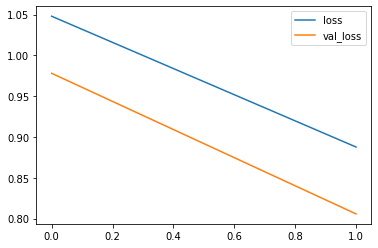

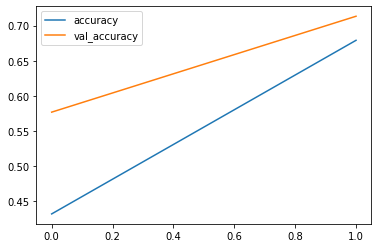

In [30]:
%%time

tf.random.set_seed(33)

MODEL_DIR = os.path.join(LOGDIR, 'dnn')
shutil.rmtree(MODEL_DIR, ignore_errors=True)

BATCH_SIZE = 300
EPOCHS = 100
EMBED_DIM = 10
PATIENCE = 0

dnn_model = build_dnn_model(embed_dim=EMBED_DIM)

dnn_history = dnn_model.fit(
    X_train, Y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_valid, Y_valid),
    callbacks=[callbacks.EarlyStopping(patience=PATIENCE),
               callbacks.TensorBoard(MODEL_DIR)],
)

pd.DataFrame(dnn_history.history)[['loss', 'val_loss']].plot()
pd.DataFrame(dnn_history.history)[['accuracy', 'val_accuracy']].plot()

dnn_model.summary()

### Transfer Learning with Pre-trained Embedding

We can also use a word embedding from a pre-trained modle using a [Neural Probabilistic Language Model](http://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf). TF-Hub has a 50-dimensional one called 
[nnlm-en-dim50-with-normalization](https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1), which also normalizes the vectors produced. 

Once loaded from its url, the TF-hub module can be used as a normal Keras layer in a sequential or functional model. Since we have enough data to fine-tune the parameters of the pre-trained embedding itself, we will set `trainable=True` in the `KerasLayer` that loads the pre-trained embedding:

In [31]:
NNLM = "https://tfhub.dev/google/nnlm-en-dim50/2"

nnlm_module = KerasLayer(
    handle=NNLM,
    output_shape=[50],
    input_shape=[],
    dtype=tf.string,
    trainable=True)

With this module, we do not need to pad our inputs. The NNLM module returns a 50-dimensional vector given a word or sentence. 

In [32]:
nnlm_module(tf.constant(["holy cash cow  batman - content is back",
                         "close look at a flu outbreak upends some common wisdom"]))

<tf.Tensor: shape=(2, 50), dtype=float32, numpy=
array([[ 0.0958989 , -0.342834  , -0.0492865 , -0.09070477,  0.15877676,
        -0.2123544 ,  0.28213888, -0.02812294, -0.07855891, -0.13102815,
         0.11162009,  0.00899507,  0.01711924,  0.3225362 , -0.13289747,
         0.11935385,  0.04386024,  0.06534779,  0.22004679, -0.13539287,
        -0.0296053 , -0.06080014,  0.12862371,  0.23304915, -0.04424817,
         0.07436226, -0.1898077 , -0.13270935,  0.21959057,  0.10597933,
         0.03580458,  0.14275001, -0.0662442 , -0.3247055 ,  0.0461876 ,
        -0.11603005,  0.06651007,  0.10887001, -0.05413236, -0.07126983,
         0.02225055,  0.26454857, -0.04697315,  0.06729111, -0.14438024,
         0.06355231, -0.05749882, -0.04587578,  0.23790349,  0.25837898],
       [ 0.11347695, -0.04064287,  0.1053718 , -0.2368139 , -0.08755025,
        -0.29770336, -0.00098698,  0.2312349 , -0.05596383,  0.04687293,
         0.07230621, -0.10018747,  0.17597003, -0.04471372, -0.16409421,
 

With this in mind, we can simplify our data inputs since do not need to integerize or pad. 

In [33]:
X_train, Y_train = titles_train.values, encode_labels(sources_train)
X_valid, Y_valid = titles_valid.values, encode_labels(sources_valid)

In [34]:
X_train[:3]

array(['holy cash cow  batman - content is back',
       'show hn  a simple and configurable deployment tool for github projects',
       'show hn  neural turing machine in pure numpy. implements all 5 tasks from paper'],
      dtype=object)

#### Build DNN model using TF-Hub Embedding layer

Next, we can add this TF-Hub module to our DNN model. 

In [35]:
def build_hub_model():
    model = models.Sequential([
        KerasLayer(handle=NNLM,
                   output_shape=[50],
                   input_shape=[],
                   dtype=tf.string,
                   trainable=True),
        layers.Dense(N_CLASSES, activation='softmax')
    ])

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [ ]:
%%time

tf.random.set_seed(33)

MODEL_DIR = os.path.join(LOGDIR, 'hub')
shutil.rmtree(MODEL_DIR, ignore_errors=True)

BATCH_SIZE = 300
EPOCHS = 100
EMBED_DIM = 10
PATIENCE = 3

hub_model = build_hub_model()

hub_history = hub_model.fit(
    X_train, Y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_valid, Y_valid),
    callbacks=[callbacks.EarlyStopping(patience=PATIENCE),
               callbacks.TensorBoard(MODEL_DIR)],
)

pd.DataFrame(hub_history.history)[['loss', 'val_loss']].plot()
pd.DataFrame(hub_history.history)[['accuracy', 'val_accuracy']].plot()

hub_model.summary()

Epoch 1/100
257/257 [==============================] - 177s 686ms/step - loss: 0.7124 - accuracy: 0.7258 - val_loss: 0.4899 - val_accuracy: 0.8127
Epoch 2/100
257/257 [==============================] - 163s 634ms/step - loss: 0.4065 - accuracy: 0.8481 - val_loss: 0.4014 - val_accuracy: 0.8392
Epoch 3/100
237/257 [==========================>...] - ETA: 12s - loss: 0.3240 - accuracy: 0.8792

Copyright 2020 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License